Importing Libraries

In [ ]:
!pip3 install snscrape
!pip3 install sentence-transformers
import snscrape.modules.twitter as twitter_scrapper
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#### Data Extraction

In [ ]:
scraped_data = []

handles = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
for account_name in handles: 
    query = "from:" + account_name
    i = 0
    for tweet in twitter_scrapper.TwitterSearchScraper(query).get_items():
        if i>=1000:
            break
        scraped_data.append([tweet.date, tweet.url, tweet.username, tweet.content])

        i += 1

column_labels = ["date", "tweet_url" , "username", "tweet"]
tweets_df = pd.DataFrame(scraped_data, columns=column_labels)


tweets_df.to_csv("data.csv")

#### Preprocessing

In [ ]:
tweets_df = pd.read_csv("data.csv" , index_col=0)

In [ ]:
tweets_df['tweet'] = tweets_df['tweet'].str.lower()
tweets_df['tweet'] = tweets_df['tweet'].str.replace(r'http\S+', '', regex=True)
tweets_df['tweet'] = tweets_df['tweet'].str.replace(r'[^0-9a-zA-Z\s]+', '', regex=True)
tweets_df['tweet'] = tweets_df['tweet'].str.replace('\d+', '')
tweets_df['tweet'] = tweets_df['tweet'].replace(r'\n+|\t+','', regex=True)
tweets_df['tweet'] = tweets_df['tweet'].str.replace(r'\s+', ' ', regex=True)
tweets_df['tweet'] = tweets_df['tweet'].str.strip()

# Reading Stop Words
file = open("./stop_words.txt", "r", encoding="utf8")
stop_words = file.read()
stop_words = stop_words.split()

tweets_df['tweet'] = tweets_df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

tweets_df['tweet'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['tweet'], inplace=True)
tweets_df.index = np.arange(len(tweets_df))

In [ ]:
train_tweets, test_tweets = train_test_split(tweets_df, test_size=0.2, shuffle=True)

train_tweets.index = np.arange(len(train_tweets))
test_tweets.index = np.arange(len(test_tweets))

### Task 1.1

#### Creating Vocab

In [ ]:
def create_vocab(df):
    vocab = list(df['tweet'].str.split(' ', expand=True).stack().unique())
    vocab = list(set(vocab))
    return vocab

vocab = create_vocab(train_tweets)

#### Bag of Word

In [ ]:
def vectorize(vocab, sentence):
    vector=[]
    for w in vocab:
        vector.append(sentence.count(w))
    return vector

def bag_of_words(df):
    bow = df.apply(lambda row: vectorize(vocab, row.str.split()['tweet']), axis=1)
    df['bag_of_words'] = bow

bag_of_words(train_tweets)
bag_of_words(test_tweets)

### Task 1.2 Embeddings

#### Creating Embeddings for each tweets

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def get_embedding(df):
    df['embeddings'] = df.apply(lambda row : model.encode(row['tweet']), axis = 1)

get_embedding(train_tweets)
get_embedding(test_tweets)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

## TASK 2: KNN

In [ ]:
# Making Generalized Functions for MFold Cross Validation and Evaluation 

def scikit_Knn (k, f_train, l_train, f_test):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(f_train, l_train)
  predicted_label = knn.predict(f_test)

  return predicted_label

def scikit_eval(l_valid, predicted_label):
  classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
  acuracy = accuracy_score(l_valid, predicted_label)

  evaluation_report = classification_report(l_valid, predicted_label,target_names=classes, output_dict=True)
  fscore = evaluation_report['macro avg']['f1-score']
  precision = evaluation_report['macro avg']['precision']
  recall = evaluation_report['macro avg']['recall']

  cm = confusion_matrix(l_valid, predicted_label, labels=classes)

  return (acuracy, precision, recall, fscore, cm)

def mFold_KNN(m, k, train_features, train_labels):
  kf = KFold(n_splits=m, random_state=None, shuffle=False)
  p_labels = list()
  for train_index, test_index in kf.split(train_features):
    X_train, X_test = train_features[train_index], train_features[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]

    predicted_label = scikit_Knn(k, list(X_train), y_train, list(X_test))
    p_labels.append(predicted_label.tolist())

  p_labels = sum(p_labels, [])
  return p_labels

### Using Embedding

In [ ]:
# Seprating features and labels
train_features = train_tweets["embeddings"]
train_labels = train_tweets["username"]

test_features = test_tweets["embeddings"]
test_labels = test_tweets["username"]

In [ ]:
# mfold cross validation
res = {}
for k in range(1,11):
    predicted_labels = mFold_KNN(5, k, train_features, train_labels)
    eval_res = scikit_eval(predicted_labels, train_labels)
    res[k] = eval_res

K-Value,1,2,3,4,5,6,7,8,9,10
accuracy,0.831997,0.811589,0.817238,0.821611,0.824344,0.822157,0.822340,0.816873,0.817420,0.816509
precision,0.828981,0.809985,0.814270,0.819002,0.821669,0.819353,0.819270,0.813949,0.814685,0.813630
recall,0.834877,0.818201,0.819367,0.825701,0.826587,0.825137,0.827084,0.821244,0.822580,0.821133
f1_score,0.828427,0.807138,0.812401,0.817379,0.819910,0.817700,0.817818,0.812255,0.813139,0.812090


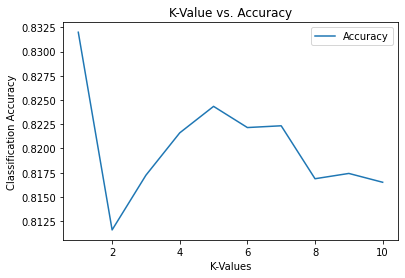

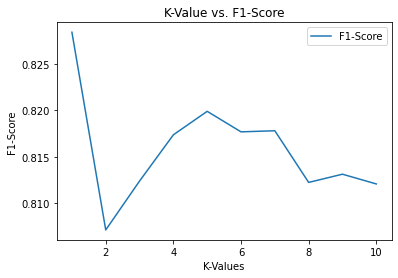

In [ ]:
# Training and Validation Losses
frame = {"accuracy": list(), "precision": list(), "recall": list(), "f1_score": list()}

for k in range(1,11):
  frame["accuracy"].append(res[k][0])
  frame["precision"].append(res[k][1])
  frame["recall"].append(res[k][2])
  frame["f1_score"].append(res[k][3])

df = pd.DataFrame(frame)
df.index = np.arange(1,11)
df.index.name = "K-Value"
df = df.T
display(df)

plt.plot(df.columns, frame['accuracy'], label = "Accuracy")
plt.xlabel("K-Values")
plt.ylabel("Classification Accuracy")
plt.title("K-Value vs. Accuracy")
plt.legend()
plt.show()

plt.plot(df.columns, frame['f1_score'], label = "F1-Score")
plt.xlabel("K-Values")
plt.ylabel("F1-Score")
plt.title("K-Value vs. F1-Score")
plt.legend()
plt.show()

Accuracy:  0.8505830903790087
Precision:  0.8526947907233621
Recall:  0.8498112200552553
F1-Score:  0.8466652560408289
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=6)')

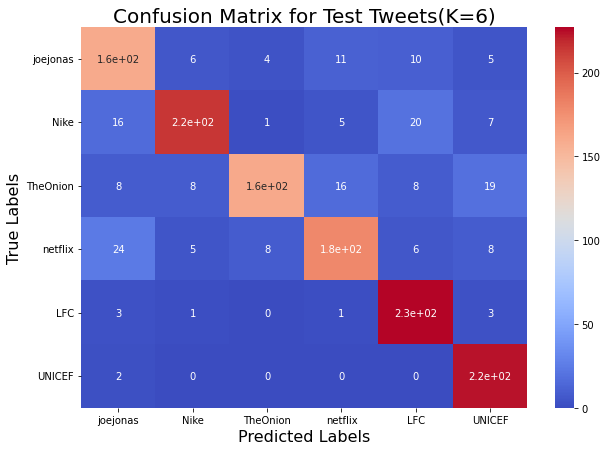

In [ ]:
# Testing on Test Data
predicted_label = scikit_Knn(6, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=6)", fontsize=20)

### Using Bag-of-Words Features

In [ ]:
# Seprating features and labels
train_features = train_tweets["bag_of_words"]
train_labels = train_tweets["username"]

test_features = test_tweets["bag_of_words"]
test_labels = test_tweets["username"]

In [ ]:
# mfold cross validation
res = {}
for k in range(1,11):
    print(k)
    predicted_labels = mFold_KNN(5, k, train_features, train_labels)
    eval_res = scikit_eval(predicted_labels, train_labels)
    res[k] = eval_res

1
2
3
4
5
6
7
8
9
10


K-Value,1,2,3,4,5,6,7,8,9,10
accuracy,0.503280,0.469570,0.473761,0.428025,0.421647,0.401239,0.386480,0.377369,0.363338,0.353316
precision,0.501141,0.468483,0.472539,0.426564,0.421102,0.401227,0.386916,0.377952,0.364414,0.354758
recall,0.686978,0.654933,0.659554,0.645927,0.644219,0.645265,0.660529,0.658985,0.674865,0.693752
f1_score,0.499530,0.447371,0.459856,0.401638,0.389615,0.366157,0.350486,0.339629,0.326554,0.317002


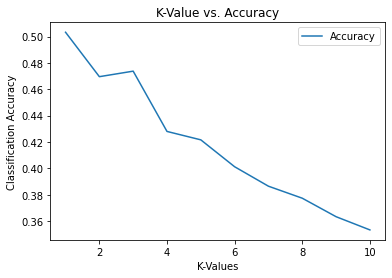

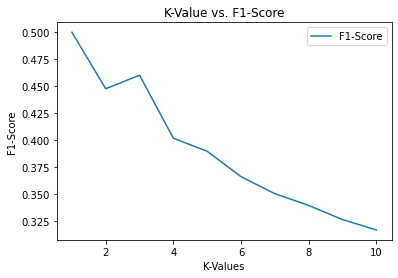

In [ ]:
# Training and Validation Losses
frame = {"accuracy": list(), "precision": list(), "recall": list(), "f1_score": list()}

for k in range(1,11):
  frame["accuracy"].append(res[k][0])
  frame["precision"].append(res[k][1])
  frame["recall"].append(res[k][2])
  frame["f1_score"].append(res[k][3])

df = pd.DataFrame(frame)
df.index = np.arange(1,11)
df.index.name = "K-Value"
df = df.T
display(df)

plt.plot(df.columns, frame['accuracy'], label = "Accuracy")
plt.xlabel("K-Values")
plt.ylabel("Classification Accuracy")
plt.title("K-Value vs. Accuracy")
plt.legend()
plt.show()

plt.plot(df.columns, frame['f1_score'], label = "F1-Score")
plt.xlabel("K-Values")
plt.ylabel("F1-Score")
plt.title("K-Value vs. F1-Score")
plt.legend()
plt.show()

Accuracy:  0.5502915451895044
Precision:  0.7112290553247523
Recall:  0.5555322654843191
F1-Score:  0.5497608556174834
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

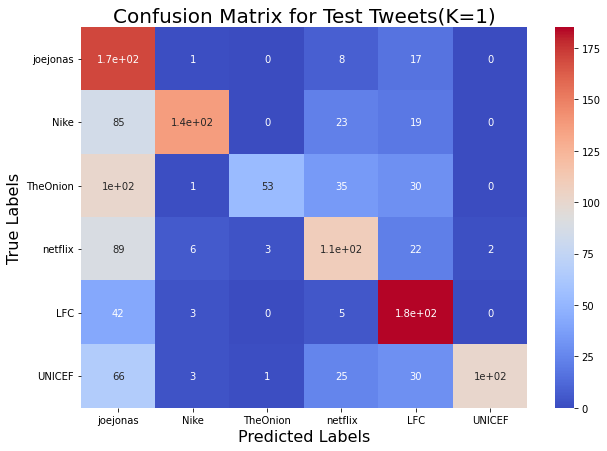

In [ ]:
# Testing on Test Data
predicted_label = scikit_Knn(1, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

## TASK 2: Neural Networks


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [ ]:
# Making Generalized Functions for MFold Cross Validation and Evaluation 

def scikit_nn (k, f_train, l_train, f_test):
  nn = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500)
  nn.fit(f_train, l_train)
  predicted_label = nn.predict(f_test)

  return predicted_label

def scikit_eval(l_valid, predicted_label):
  classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
  acuracy = accuracy_score(l_valid, predicted_label)

  evaluation_report = classification_report(l_valid, predicted_label,target_names=classes, output_dict=True)
  fscore = evaluation_report['macro avg']['f1-score']
  precision = evaluation_report['macro avg']['precision']
  recall = evaluation_report['macro avg']['recall']

  cm = confusion_matrix(l_valid, predicted_label, labels=classes)

  return (acuracy, precision, recall, fscore, cm)

def mFold_NN(m, k, train_features, train_labels):
  kf = KFold(n_splits=m, random_state=None, shuffle=False)
  p_labels = list()
  for train_index, test_index in kf.split(train_features):
    X_train, X_test = train_features[train_index], train_features[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]

    predicted_label = scikit_nn(k, list(X_train), y_train, list(X_test))
    p_labels.append(predicted_label.tolist())

  p_labels = sum(p_labels, [])
  return p_labels

## Neural Networks for embeddings

In [ ]:
# Seprating features and labels
train_features = train_tweets["embeddings"]
train_labels = train_tweets["username"]

test_features = test_tweets["embeddings"]
test_labels = test_tweets["username"]

In [ ]:
# mfold cross validation
res = {}
for k in range(1,11):
    predicted_labels = mFold_NN(5, k, train_features, train_labels)
    eval_res = scikit_eval(predicted_labels, train_labels)
    res[k] = eval_res

K-Value,1,2,3,4,5,6,7,8,9,10
accuracy,0.825255,0.821246,0.824891,0.827806,0.821246,0.825802,0.821611,0.822522,0.822886,0.819060
precision,0.824676,0.820898,0.824338,0.827474,0.820745,0.825400,0.820921,0.821859,0.822254,0.818545
recall,0.823857,0.819930,0.824590,0.826390,0.819830,0.824802,0.820396,0.821705,0.821540,0.817851
f1_score,0.824190,0.820278,0.824350,0.826878,0.820145,0.825024,0.820594,0.821701,0.821839,0.818084


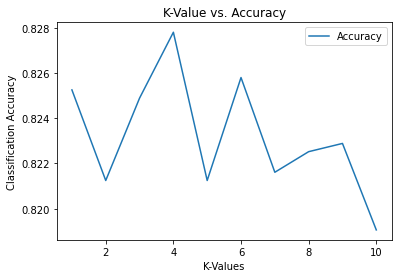

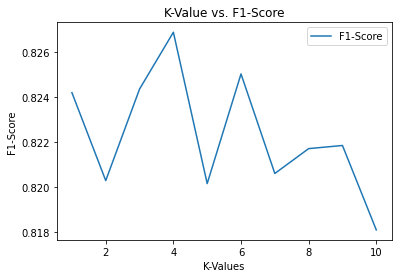

In [ ]:
# Training and Validation Losses
frame = {"accuracy": list(), "precision": list(), "recall": list(), "f1_score": list()}

for k in range(1,11):
  frame["accuracy"].append(res[k][0])
  frame["precision"].append(res[k][1])
  frame["recall"].append(res[k][2])
  frame["f1_score"].append(res[k][3])

df = pd.DataFrame(frame)
df.index = np.arange(1,11)
df.index.name = "K-Value"
df = df.T
display(df)

plt.plot(df.columns, frame['accuracy'], label = "Accuracy")
plt.xlabel("K-Values")
plt.ylabel("Classification Accuracy")
plt.title("K-Value vs. Accuracy")
plt.legend()
plt.show()

plt.plot(df.columns, frame['f1_score'], label = "F1-Score")
plt.xlabel("K-Values")
plt.ylabel("F1-Score")
plt.title("K-Value vs. F1-Score")
plt.legend()
plt.show()

Accuracy:  0.8440233236151603
Precision:  0.8410588333441481
Recall:  0.8411244252127054
F1-Score:  0.8406389181508024
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=6)')

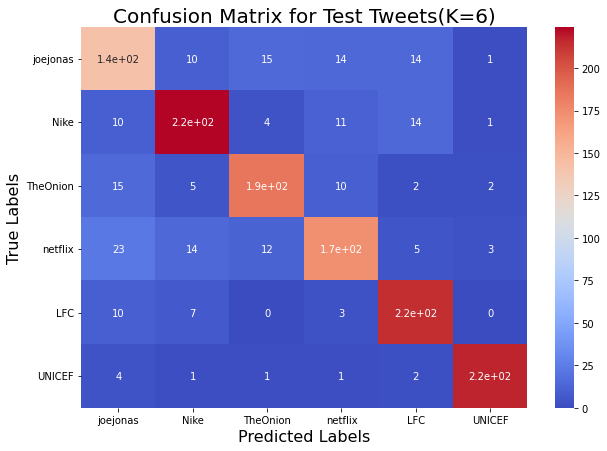

In [ ]:
# Testing on Test Data
predicted_label = scikit_nn(6, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=6)", fontsize=20)

## Neural Networks for Bag of Words

In [ ]:
# Seprating features and labels
train_features = train_tweets["bag_of_words"]
train_labels = train_tweets["username"]

test_features = test_tweets["bag_of_words"]
test_labels = test_tweets["username"]

In [ ]:
# mfold cross validation
res = {}
for k in range(1,11):
    print(k)
    predicted_labels = mFold_NN(5, k, train_features, train_labels)
    eval_res = scikit_eval(predicted_labels, train_labels)
    res[k] = eval_res

1
2
3
4
5
6
7
8
9
10


K-Value,1,2,3,4,5,6,7,8,9,10
accuracy,0.833455,0.834730,0.835459,0.835277,0.836735,0.839468,0.840379,0.835641,0.832726,0.834366
precision,0.830573,0.831557,0.832549,0.832596,0.833775,0.836728,0.837580,0.832724,0.829717,0.831406
recall,0.841222,0.841056,0.842814,0.842027,0.842114,0.844630,0.845577,0.840997,0.839570,0.840536
f1_score,0.831970,0.832433,0.833665,0.833741,0.834619,0.837790,0.838428,0.833610,0.830953,0.832462


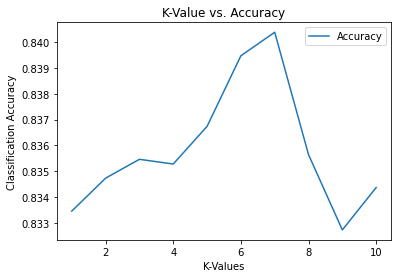

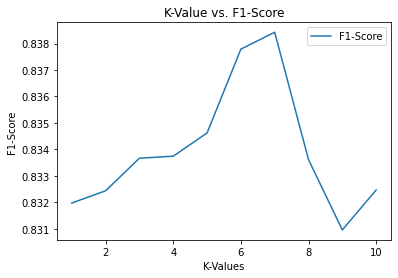

In [ ]:
# Training and Validation Losses
frame = {"accuracy": list(), "precision": list(), "recall": list(), "f1_score": list()}

for k in range(1,11):
  frame["accuracy"].append(res[k][0])
  frame["precision"].append(res[k][1])
  frame["recall"].append(res[k][2])
  frame["f1_score"].append(res[k][3])

df = pd.DataFrame(frame)
df.index = np.arange(1,11)
df.index.name = "K-Value"
df = df.T
display(df)

plt.plot(df.columns, frame['accuracy'], label = "Accuracy")
plt.xlabel("K-Values")
plt.ylabel("Classification Accuracy")
plt.title("K-Value vs. Accuracy")
plt.legend()
plt.show()

plt.plot(df.columns, frame['f1_score'], label = "F1-Score")
plt.xlabel("K-Values")
plt.ylabel("F1-Score")
plt.title("K-Value vs. F1-Score")
plt.legend()
plt.show()

Accuracy:  0.8607871720116618
Precision:  0.8650452179775936
Recall:  0.8602001613823441
F1-Score:  0.8584739052333007
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

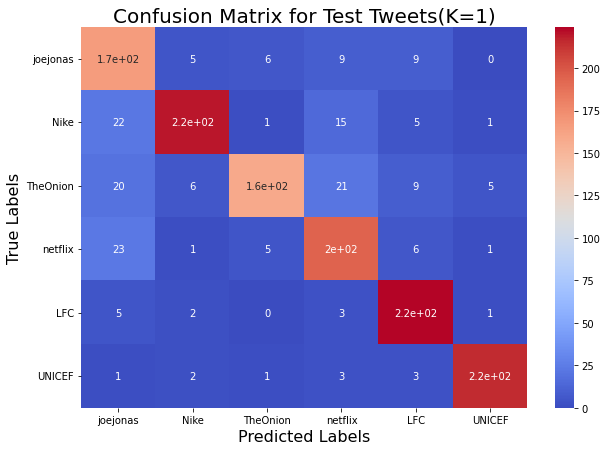

In [ ]:
# Testing on Test Data
predicted_label = scikit_nn(1, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500)
cross_val = cross_val_score(model, train_features, train_labels, cv=5)
print(cross_val)
model.fit(train_features, train_labels)
predictions = model.predict(test_features)
print("Loss: ", model.loss_)
print(classification_report(test_labels, predictions))
print(confusion_matrix(test_labels, predictions))
print("Accuracy: ", accuracy_score(test_labels, predictions))
print("Precision: ", precision_score(test_labels, predictions, average='macro'))
print("Recall: ", recall_score(test_labels, predictions, average='macro'))
print("F1 Score: ", f1_score(test_labels, predictions, average='macro'))

## Task4: Ensemble Method

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#### Bagging Classifier for Bag of Words

In [ ]:
# Seprating features and labels
train_features = train_tweets["bag_of_words"]
train_labels = train_tweets["username"]

test_features = test_tweets["bag_of_words"]
test_labels = test_tweets["username"]

In [ ]:
def scikit_bagging(k, f_train, l_train, f_test):
  nn = BaggingClassifier()
  nn.fit(f_train, l_train)
  predicted_label = nn.predict(f_test)

  return predicted_label

Accuracy:  0.7944606413994169
Precision:  0.8180777568430768
Recall:  0.7964433106964108
F1-Score:  0.796579667028997
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

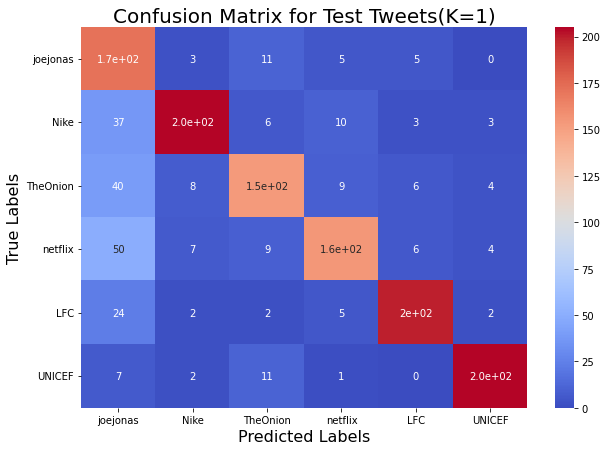

In [ ]:
# Testing on Test Data
predicted_label = scikit_bagging(1, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

#### Bagging Classifier for Embeddings

In [ ]:
# Seprating features and labels
train_features = train_tweets["embeddings"]
train_labels = train_tweets["username"]

test_features = test_tweets["embeddings"]
test_labels = test_tweets["username"]

In [ ]:
def scikit_bagging(k, f_train, l_train, f_test):
  nn = BaggingClassifier()
  nn.fit(f_train, l_train)
  predicted_label = nn.predict(f_test)

  return predicted_label

Accuracy:  0.6771137026239067
Precision:  0.6746964568225268
Recall:  0.6742105756049188
F1-Score:  0.6713118758129079
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

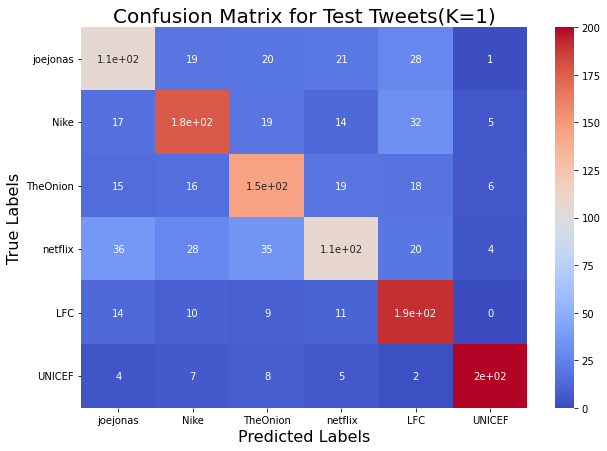

In [ ]:
# Testing on Test Data
predicted_label = scikit_bagging(1, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

### Random Forest Classifier for Bag of Words

In [ ]:
# Seprating features and labels
train_features = train_tweets["bag_of_words"]
train_labels = train_tweets["username"]

test_features = test_tweets["bag_of_words"]
test_labels = test_tweets["username"]

In [ ]:
def scikit_randomforest(k, f_train, l_train, f_test):
  nn = RandomForestClassifier()
  nn.fit(f_train, l_train)
  predicted_label = nn.predict(f_test)

  return predicted_label

Accuracy:  0.8119533527696793
Precision:  0.8411196927837116
Recall:  0.8149183786419174
F1-Score:  0.8146745657096691
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

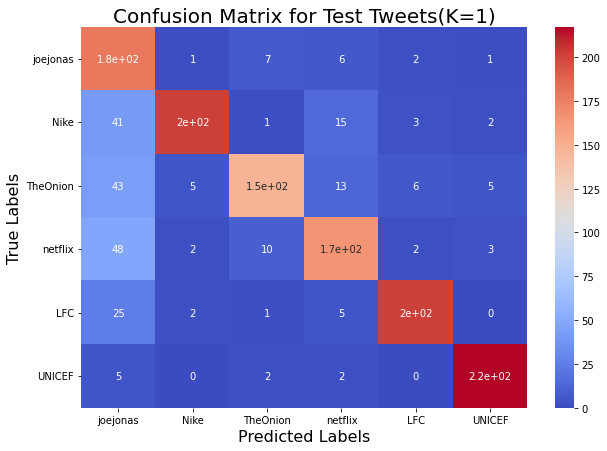

In [ ]:
# Testing on Test Data
predicted_label = scikit_randomforest(1, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

### Random Forest Classifier for Embeddings

In [ ]:
# Seprating features and labels
train_features = train_tweets["embeddings"]
train_labels = train_tweets["username"]

test_features = test_tweets["embeddings"]
test_labels = test_tweets["username"]

In [ ]:
def scikit_randomforest(k, f_train, l_train, f_test):
  nn = RandomForestClassifier()
  nn.fit(f_train, l_train)
  predicted_label = nn.predict(f_test)

  return predicted_label

Accuracy:  0.8075801749271136
Precision:  0.8087059034226236
Recall:  0.8082566133555321
F1-Score:  0.80638882886991
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

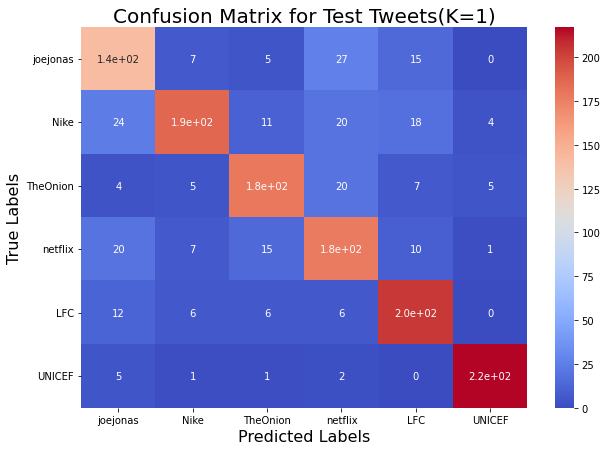

In [ ]:
# Testing on Test Data
predicted_label = scikit_randomforest(1, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

### AdaBoost Classifier for Bag of Words

In [ ]:
# Seprating features and labels
train_features = train_tweets["bag_of_words"]
train_labels = train_tweets["username"]

test_features = test_tweets["bag_of_words"]
test_labels = test_tweets["username"]

In [ ]:
def scikit_adaboost(k, f_train, l_train, f_test):
  nn = AdaBoostClassifier()
  nn.fit(f_train, l_train)
  predicted_label = nn.predict(f_test)

  return predicted_label

Accuracy:  0.564868804664723
Precision:  0.816366442198223
Recall:  0.5744657023898894
F1-Score:  0.5839397941173329
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

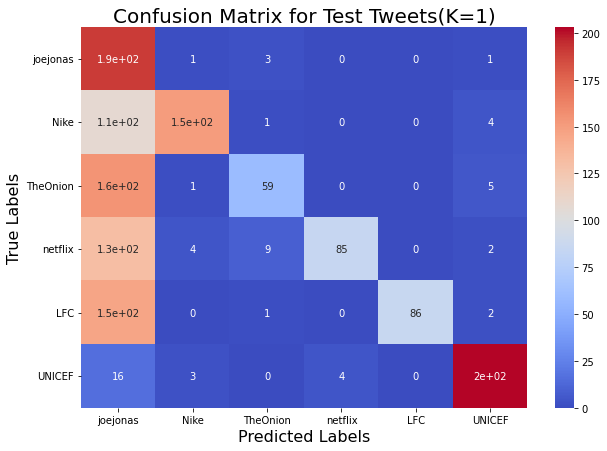

In [ ]:
# Testing on Test Data
predicted_label = scikit_adaboost(1, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

### AdaBoost Classifier for Embeddings

In [ ]:
# Seprating features and labels
train_features = train_tweets["embeddings"]
train_labels = train_tweets["username"]

test_features = test_tweets["embeddings"]
test_labels = test_tweets["username"]

In [ ]:
def scikit_adaboost(k, f_train, l_train, f_test):
  nn = AdaBoostClassifier()
  nn.fit(f_train, l_train)
  predicted_label = nn.predict(f_test)

  return predicted_label

Accuracy:  0.6034985422740525
Precision:  0.6058815088717641
Recall:  0.5990461050935268
F1-Score:  0.6016914463227931
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

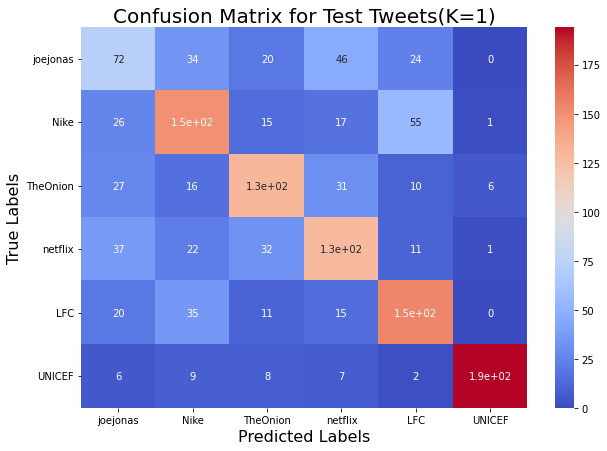

In [ ]:
# Testing on Test Data
predicted_label = scikit_adaboost(1, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

### ExtraTrees Classifier for Bag of Words

In [ ]:
# Seprating features and labels
train_features = train_tweets["bag_of_words"]
train_labels = train_tweets["username"]

test_features = test_tweets["bag_of_words"]
test_labels = test_tweets["username"]

In [ ]:
def scikit_extratrees(k, f_train, l_train, f_test):
  nn = ExtraTreesClassifier()
  nn.fit(f_train, l_train)
  predicted_label = nn.predict(f_test)

  return predicted_label

Accuracy:  0.8228862973760933
Precision:  0.8409102387133779
Recall:  0.8246045971494501
F1-Score:  0.8235723667997834
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

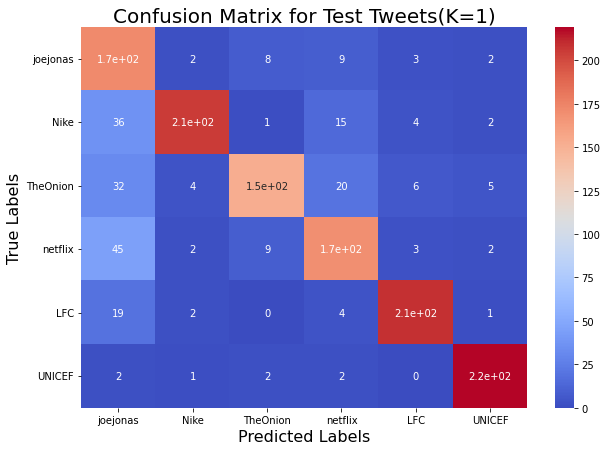

In [ ]:
# Testing on Test Data
predicted_label = scikit_extratrees(1, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

### ExtraTrees Classifier for Embeddings

In [ ]:
# Seprating features and labels
train_features = train_tweets["embeddings"]
train_labels = train_tweets["username"]

test_features = test_tweets["embeddings"]
test_labels = test_tweets["username"]

In [ ]:
def scikit_extratrees(k, f_train, l_train, f_test):
  nn = ExtraTreesClassifier()
  nn.fit(f_train, l_train)
  predicted_label = nn.predict(f_test)

  return predicted_label

Accuracy:  0.8090379008746356
Precision:  0.8095649691539943
Recall:  0.8083674535812283
F1-Score:  0.8067467755414764
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

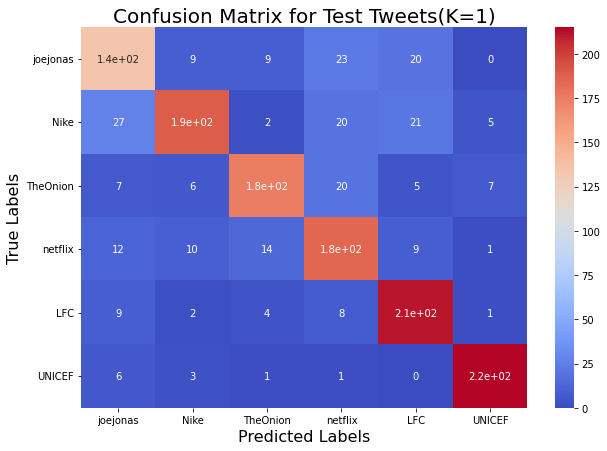

In [ ]:
# Testing on Test Data
predicted_label = scikit_extratrees(1, list(train_features), train_labels, list(test_features))

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

### Voting Classifier for Bag of Words

In [ ]:
# Seprating features and labels
train_features = train_tweets["bag_of_words"]
train_labels = train_tweets["username"]

test_features = test_tweets["bag_of_words"]
test_labels = test_tweets["username"]

In [ ]:
def scikit_voting(k, f_train, l_train, f_test, classifiers):
  nn = VotingClassifier(estimators=classifiers)
  nn.fit(f_train, l_train)
  predicted_label = nn.predict(f_test)

  return predicted_label

In [ ]:
lr = LogisticRegression(random_state=1)

knn = KNeighborsClassifier(n_neighbors=3)

dt = DecisionTreeClassifier(min_samples_leaf=0.1, random_state=1)

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

Accuracy:  0.771865889212828
Precision:  0.7961849504497684
Recall:  0.7713332370543146
F1-Score:  0.7700062044919797
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

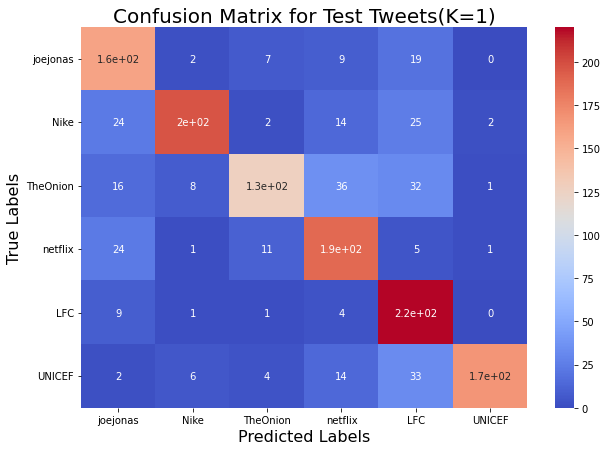

In [ ]:
# Testing on Test Data
predicted_label = scikit_voting(1, list(train_features), train_labels, list(test_features), classifiers)

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

### Voting Classifier for Embeddings

In [ ]:
# Seprating features and labels
train_features = train_tweets["embeddings"]
train_labels = train_tweets["username"]

test_features = test_tweets["embeddings"]
test_labels = test_tweets["username"]

In [ ]:
def scikit_voting(k, f_train, l_train, f_test, classifiers):
  nn = VotingClassifier(estimators=classifiers)
  nn.fit(f_train, l_train)
  predicted_label = nn.predict(f_test)

  return predicted_label

In [ ]:
lr = LogisticRegression(random_state=1)

knn = KNeighborsClassifier(n_neighbors=3)

dt = DecisionTreeClassifier(min_samples_leaf=0.1, random_state=1)

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

Accuracy:  0.8294460641399417
Precision:  0.8371780196494015
Recall:  0.8268684344783143
F1-Score:  0.8267343490229296
Confusion Matrix



Text(0.5, 1.0, 'Confusion Matrix for Test Tweets(K=1)')

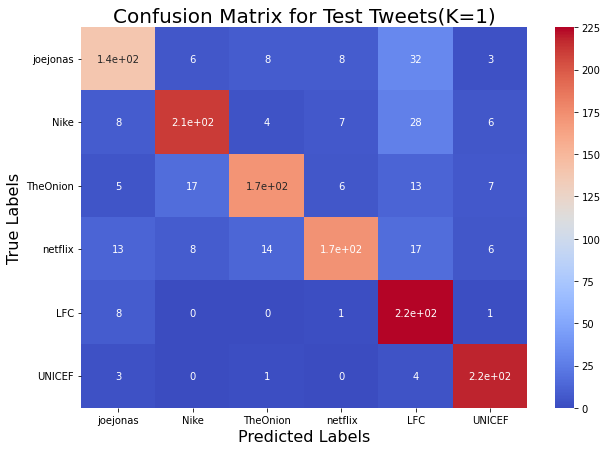

In [ ]:
# Testing on Test Data
predicted_label = scikit_voting(1, list(train_features), train_labels, list(test_features), classifiers)

# Results on Test Data
eval_res = scikit_eval(test_labels, predicted_label)

print("Accuracy: ", eval_res[0])
print("Precision: ", eval_res[1])
print("Recall: ", eval_res[2])
print("F1-Score: ", eval_res[3])
print("Confusion Matrix\n")

classes = ["joejonas", "Nike", "TheOnion", "netflix" , "LFC" , "UNICEF"]
plt.figure(figsize = (10,7))
g = sns.heatmap(eval_res[4], annot=True, cmap='coolwarm')
g.set_xticklabels(labels = classes)
g.set_yticklabels(labels = classes, rotation=0)
plt.xlabel("Predicted Labels", fontsize=16)
plt.ylabel("True Labels", fontsize=16)
plt.title("Confusion Matrix for Test Tweets(K=1)", fontsize=20)

# Task 5: Theoretical Understanding

#### Q1. Which model performed best and why do you think that is?

#### Ans: Neural Networks performed best for our dataset, and this is because neural networks are much more powerful than other classifiers because like other classifiers neural networks can have more powerful decision boundary. Neural Networks don’t consider any relationship between the words because there is none in the bag of words we are using. As there is no relationship between words in bag of words, a classifier that considers it, KNN, will perform worse than a model like Neural Networks that doesn’t consider it.

#### Q2. Which features gave better results for each model? Explain.

#### Ans: Embeddings were better than bag of words on average and this is because the presence of context implies that embeddings have an advantage over the normal features based on simple counts, since our features supply a higher quality input, and thus our models will perform better as a result of the denser and relevant information they encode.

#### Q3. What effect would increasing the classes to 150 have?

#### Ans: Accuracy and F1 score will fall overall. This is because the data is 1000 tweets per class for now and if the classes are increased, 1000 tweets per class account for less as a percentage of the whole dataset. So, more classes mean less data for each class as compared to the whole leading to increased inaccuracy.

#### Q4. Suggest improvements to text preparation, feature extraction, and models that can be made to perform this task better.

#### Ans: We could utilize the nltk library for data pre-processing and data preparation along with keeping the hashtags, mentions, and emojis in the tweets since they are highly utilized in most tweets nowadays and can help with authorship attribution. Furthermore, a grid search utilizing multiple parameters, along with not removing stopwords can be implemented. Lastly, we could use a Naïve Bayes Classifier model too for our dataset since it works very well on textual data and can perform well with authorship attribution.

#### Q5. What - in your understanding - are the applications of authorship attribution?

#### Ans: Authorship attribution can help us determine whether a piece of text can belong to an author or not. This can be useful in cases such as whether a person can write those words or not, in cases of checking plagiarism, in criminal investigations, and can also have financial and legal uses